
# Applying Temporal Convonotional Networks to the Virtual Flow Metering Problem 

## Author: Ridha Alkhabaz 

### Imports:

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [11]:
# for tcn applications
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, RepeatVector
from tensorflow.keras.preprocessing import sequence
from tcn import TCN
import tensorflow as tf
import os
os.chdir("/Users/ridhaalkhabaz/Documents/GitHub/ElectricDemandForecasting-DL/src")
# for data configurations
import sys
import json
import random
import pandas as pd
import matplotlib.pyplot as plt
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import adjusted_rand_score
import datetime as dttm
os.chdir('/Users/ridhaalkhabaz/Documents/GitHub/VFM_ML/src')
from preprocessing import read_data_slugging, read_data_well, multivariate_data
from configuration import configure 
os.chdir("/Users/ridhaalkhabaz/Documents/GitHub/VFM_ML")
from main import model_init, model_train, model_predict

### Data configuration and Reading:

#### First: Riser data:

##### Reading the data and formating: ( Sliding window technique (Data configuration))

In [4]:
os.chdir("/Users/ridhaalkhabaz/Documents/GitHub/VFM_ML")
from main import model_init, model_train, model_predict
data_riser,headers, _= read_data_slugging('riser_pq_uni.csv', plot_data=False)
df_riser = pd.DataFrame.from_dict(dict(zip(['ds', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7','gas(m3/day)', 'liquid(m3/day)' ], data_riser.T)))
### previous readings for univariate model 
dt_gas_riser = np.array(df_riser['gas(m3/day)'])
dt_liquid_riser = np.array(df_riser['liquid(m3/day)'])
### gas and liquid dataframe
df_gas_riser = df_riser.drop('liquid(m3/day)', axis=1)
df_gas_riser = df_gas_riser.set_index('ds')
df_liquid_riser = df_riser.drop('gas(m3/day)', axis=1)
df_liquid_riser = df_liquid_riser.set_index('ds')

#### GAS (models)
##### Univariate & Multivariate Model:

In [4]:
model_gas_TCN_uni = model_init(model='TCN', params=['past_readings'], \
                           hyperparamters=[{'input_shape':(300,1), 'nb_filters':64, 'kernel_size':4}, 5])
model_gas_TCN_mult = model_init(model='TCN', params=['past_readings', 'pressure readings'], \
                           hyperparamters=[{'input_shape':(300,8), 'nb_filters':64, 'kernel_size':4}, 5])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 64)                181376    
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 181,701
Trainable params: 181,701
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_1 (TCN)                  (None, 64)                183616    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 183,941
Trainable params: 183,941
Non-trainable params: 0
_________________________________________________________________


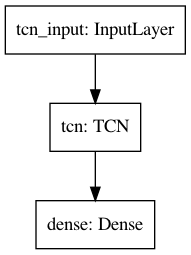

In [5]:
import pydot
import pydotplus
import graphviz
tf.keras.utils.plot_model(
    model_gas_TCN_uni,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

#### LIQUID (models)
##### Univariate & Multivariate Model:

In [6]:
model_liquid_TCN_uni = model_init(model='TCN', params=['past_readings'],\
                                  hyperparamters=[{'input_shape':(300,1), 'nb_filters':128, 'kernel_size':4}, 5])
model_liquid_TCN_mult = model_init(model='TCN', params=['past_readings', 'pressure readings'],\
                                  hyperparamters=[{'input_shape':(300,8), 'nb_filters':128, 'kernel_size':4}, 5])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_2 (TCN)                  (None, 128)               723200    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 723,845
Trainable params: 723,845
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_3 (TCN)                  (None, 128)               727680    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 728,325
Trainable params: 728,325
Non-trainable params: 0
_________________________________________________________________


#### Data configuration for training and testing:

In [7]:
## gas (uni & multi)
gas_uni_train, gas_uni_val, gas_uni_testX, gas_uni_testY = configure(dt_gas_riser, params = [0, 1500, 2500, 2999], multi = False)
gas_mult_train, gas_mult_val, gas_mult_testX, gas_mult_testY = configure(df_gas_riser, params = [0, 1500, 2500, 2999], multi = True)
##liquid (uni & multi)
liq_uni_train, liq_uni_val, liq_uni_testX, liq_uni_testY= configure(dt_liquid_riser, params = [0, 1500, 2500, 2999], multi = False)
liq_mult_train, liq_mult_val, liq_mult_testX, liq_mult_testY = configure(df_liquid_riser, params = [0, 1500, 2500, 2999], multi = True)

#### Training:

In [18]:
# Univariate - GAS 
model_trained_gas_uni = model_train(gas_uni_train, 'gas(kg/sec)',\
                                    model_gas_TCN_uni, 'TCN', [50, 10], gas_uni_val)

Epoch 1/50
10/10 [==============================] - 7s 505ms/step - loss: 18.3742 - val_loss: 0.2180
Epoch 2/50
10/10 [==============================] - 4s 445ms/step - loss: 0.1612 - val_loss: 0.0769
Epoch 3/50
10/10 [==============================] - 4s 454ms/step - loss: 0.0558 - val_loss: 0.0346
Epoch 4/50
10/10 [==============================] - 4s 450ms/step - loss: 0.0266 - val_loss: 0.0197
Epoch 5/50
10/10 [==============================] - 4s 454ms/step - loss: 0.0159 - val_loss: 0.0154
Epoch 6/50
10/10 [==============================] - 4s 448ms/step - loss: 0.0120 - val_loss: 0.0120
Epoch 7/50
10/10 [==============================] - 5s 458ms/step - loss: 0.0091 - val_loss: 0.0103
Epoch 8/50
10/10 [==============================] - 4s 452ms/step - loss: 0.0076 - val_loss: 0.0090
Epoch 9/50
10/10 [==============================] - 4s 453ms/step - loss: 0.0063 - val_loss: 0.0081
Epoch 10/50
10/10 [==============================] - 4s 446ms/step - loss: 0.0055 - val_loss: 0.007

In [19]:
# multivariate - GAS
model_trained_gas_multi = model_train(gas_mult_train, 'gas(kg/sec)', model_gas_TCN_mult, 'TCN', [50, 10], gas_mult_val)

Epoch 1/50
10/10 [==============================] - 7s 487ms/step - loss: 80.5553 - val_loss: 0.8088
Epoch 2/50
10/10 [==============================] - 4s 452ms/step - loss: 0.4686 - val_loss: 0.1537
Epoch 3/50
10/10 [==============================] - 4s 454ms/step - loss: 0.0884 - val_loss: 0.0402
Epoch 4/50
10/10 [==============================] - 4s 454ms/step - loss: 0.0380 - val_loss: 0.0251
Epoch 5/50
10/10 [==============================] - 4s 454ms/step - loss: 0.0228 - val_loss: 0.0198
Epoch 6/50
10/10 [==============================] - 4s 450ms/step - loss: 0.0178 - val_loss: 0.0156
Epoch 7/50
10/10 [==============================] - 5s 463ms/step - loss: 0.0139 - val_loss: 0.0127
Epoch 8/50
10/10 [==============================] - 4s 454ms/step - loss: 0.0121 - val_loss: 0.0110
Epoch 9/50
10/10 [==============================] - 5s 463ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 10/50
10/10 [==============================] - 4s 456ms/step - loss: 0.0092 - val_loss: 0.008

In [10]:
# Univariate - Liquid 
model_trained_liquid_uni = model_train(liq_uni_train, 'gas(kg/sec)', model_liquid_TCN_uni,\
                                      'TCN', [50, 10], liq_uni_val)

Epoch 1/50
10/10 [==============================] - 14s 1s/step - loss: 26.6832 - val_loss: 0.5715
Epoch 2/50
10/10 [==============================] - 11s 1s/step - loss: 0.3822 - val_loss: 0.1043
Epoch 3/50
10/10 [==============================] - 11s 1s/step - loss: 0.0825 - val_loss: 0.0496
Epoch 4/50
10/10 [==============================] - 11s 1s/step - loss: 0.0386 - val_loss: 0.0232
Epoch 5/50
10/10 [==============================] - 11s 1s/step - loss: 0.0196 - val_loss: 0.0137
Epoch 6/50
10/10 [==============================] - 11s 1s/step - loss: 0.0119 - val_loss: 0.0098
Epoch 7/50
10/10 [==============================] - 11s 1s/step - loss: 0.0077 - val_loss: 0.0077
Epoch 8/50
10/10 [==============================] - 11s 1s/step - loss: 0.0059 - val_loss: 0.0065
Epoch 9/50
10/10 [==============================] - 11s 1s/step - loss: 0.0043 - val_loss: 0.0055
Epoch 10/50
10/10 [==============================] - 11s 1s/step - loss: 0.0034 - val_loss: 0.0048
Epoch 11/50
10/10 

In [11]:
# Multivariate - Liquid 
model_trained_liquid_mult = model_train(liq_mult_train, 'gas(kg/sec)', model_liquid_TCN_mult,\
                                      'TCN', [50, 10], liq_mult_val)

Epoch 1/50
10/10 [==============================] - 14s 1s/step - loss: 92.0568 - val_loss: 0.6560
Epoch 2/50
10/10 [==============================] - 11s 1s/step - loss: 0.4624 - val_loss: 0.1079
Epoch 3/50
10/10 [==============================] - 11s 1s/step - loss: 0.1063 - val_loss: 0.0649
Epoch 4/50
10/10 [==============================] - 11s 1s/step - loss: 0.0490 - val_loss: 0.0326
Epoch 5/50
10/10 [==============================] - 11s 1s/step - loss: 0.0271 - val_loss: 0.0166
Epoch 6/50
10/10 [==============================] - 11s 1s/step - loss: 0.0164 - val_loss: 0.0133
Epoch 7/50
10/10 [==============================] - 11s 1s/step - loss: 0.0117 - val_loss: 0.0096
Epoch 8/50
10/10 [==============================] - 11s 1s/step - loss: 0.0093 - val_loss: 0.0072
Epoch 9/50
10/10 [==============================] - 12s 1s/step - loss: 0.0069 - val_loss: 0.0060
Epoch 10/50
10/10 [==============================] - 11s 1s/step - loss: 0.0059 - val_loss: 0.0054
Epoch 11/50
10/10 

In [17]:
[mse(gas_uni_testY.flatten(), model_gas_uni.predict(gas_uni_testX).flatten()),\
 mse(gas_mult_testY.flatten(), model_gas_mult.predict(gas_mult_testX).flatten()),\
 mse(liq_uni_testY.flatten(), model_liq_uni.predict(liq_uni_testX).flatten()),\
 mse(liq_mult_testY.flatten(), model_liquid_mult.predict(liq_mult_testX).flatten())]

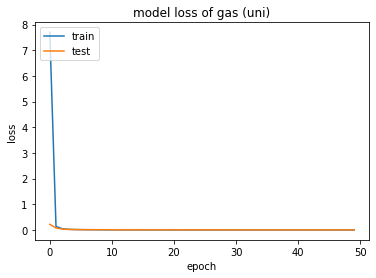

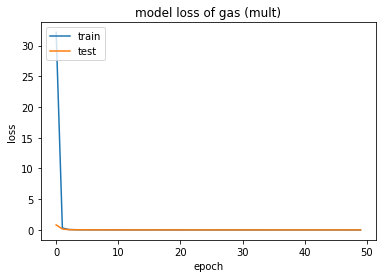

In [20]:
## GAS 
# summarize history for loss
plt.plot(model_trained_gas_uni.history['loss'])
plt.plot(model_trained_gas_uni.history['val_loss'])
plt.title('model loss of gas (uni)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_trained_gas_multi.history['loss'])
plt.plot(model_trained_gas_multi.history['val_loss'])
plt.title('model loss of gas (mult)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

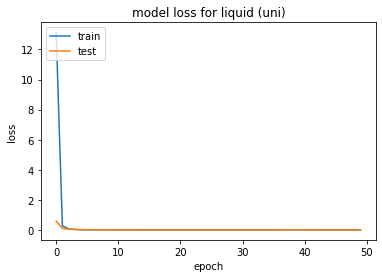

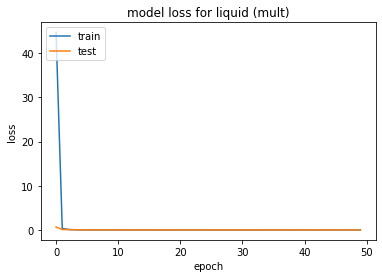

In [14]:
## Liquid 
plt.plot(model_trained_liquid_uni.history['loss'])
plt.plot(model_trained_liquid_uni.history['val_loss'])
plt.title('model loss for liquid (uni)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(model_trained_liquid_mult.history['loss'])
plt.plot(model_trained_liquid_mult.history['val_loss'])
plt.title('model loss for liquid (mult)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
## gas testing data set visualization
### univariate 
real_gas_uni = gas_uni_testY.flatten()
pred_gas_uni = model_gas_TCN_uni.predict(gas_uni_testX).flatten()
df_plot_gas_uni=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_gas_uni, real_gas_uni]))))
df_plot_gas_uni['ds']=range(2805,3000)
# ### multivariate 
real_gas_mult = gas_mult_testY.flatten()
pred_gas_mult = model_gas_TCN_mult.predict(gas_mult_testX).flatten()
df_plot_gas_mult=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_gas_mult, real_gas_mult]))))
df_plot_gas_mult['ds']=range(2800,3000)
# ##liquid
# ## univariate
real_liq_uni = liq_uni_testY.flatten()
pred_liq_uni = model_liquid_TCN_uni.predict(liq_uni_testX).flatten()
df_plot_liq_uni=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_liq_uni, real_liq_uni]))))
df_plot_liq_uni['ds']=range(2805,3000)
## multivariate 
real_liq_mult = liq_mult_testY.flatten()
pred_liq_mult = model_liquid_TCN_mult.predict(liq_mult_testX).flatten()
df_plot_liq_mult=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_liq_mult, real_liq_mult]))))
df_plot_liq_mult['ds']=range(2800,3000)

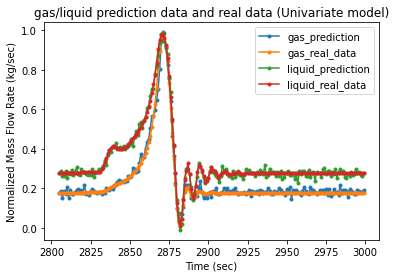

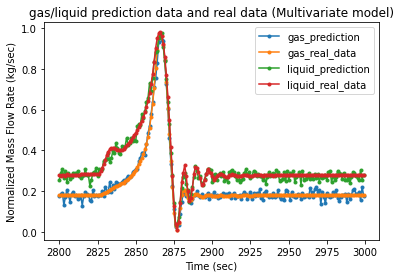

In [22]:
start = 0
end = 1000
fig,ax = plt.subplots()
ax.set_title('gas/liquid prediction data and real data (Univariate model)')
ax.plot(df_plot_gas_uni['ds'].iloc[start:end], df_plot_gas_uni['prediction'].iloc[start:end], marker=".", label='gas_prediction')
ax.plot(df_plot_gas_uni['ds'].iloc[start:end], df_plot_gas_uni['real'].iloc[start:end], marker=".", label='gas_real_data')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Normalized Mass Flow Rate (kg/sec)')
ax.plot(df_plot_liq_uni['ds'].iloc[start:end], df_plot_liq_uni['prediction'].iloc[start:end], marker=".", label='liquid_prediction')
ax.plot(df_plot_liq_uni['ds'].iloc[start:end], df_plot_liq_uni['real'].iloc[start:end], marker=".", label='liquid_real_data')
ax.legend()
# fig.savefig('tcn-riser-uni-clean.jpeg')
fig,ax = plt.subplots()
ax.set_title('gas/liquid prediction data and real data (Multivariate model)')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Normalized Mass Flow Rate (kg/sec)')
ax.plot(df_plot_gas_mult['ds'].iloc[start:end], df_plot_gas_mult['prediction'].iloc[start:end], marker=".", label='gas_prediction')
ax.plot(df_plot_gas_mult['ds'].iloc[start:end], df_plot_gas_mult['real'].iloc[start:end], marker=".", label='gas_real_data')
ax.plot(df_plot_liq_mult['ds'].iloc[start:end], df_plot_liq_mult['prediction'].iloc[start:end], marker=".", label='liquid_prediction')
ax.plot(df_plot_liq_mult['ds'].iloc[start:end], df_plot_liq_mult['real'].iloc[start:end], marker=".", label='liquid_real_data')
ax.legend()
# fig.savefig('tcn-riser-multi-clean.jpeg')

## The well dataset 

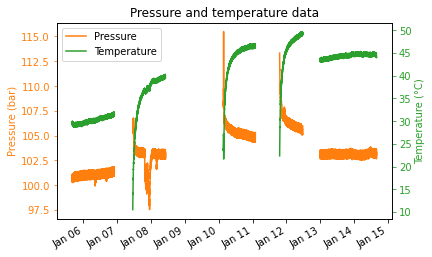

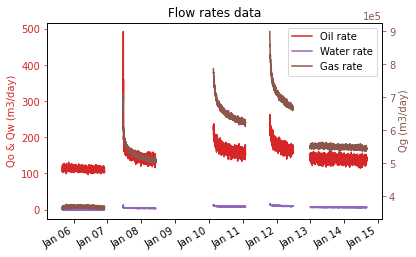

In [5]:
fp, headers, scaler = read_data_well('welltest.csv', plot_data=True)
df = pd.DataFrame.from_dict(dict(zip(['ds', 'pressure', 'temperature', 'oil', 'water', 'gas'], fp[0].T)))
for i in [1,2, 3, 4]:
    time_a = str(df.iloc[-1].ds)
    tmp = pd.DataFrame.from_dict(dict(zip(['ds', 'pressure', 'temperature', 'oil', 'water', 'gas'], fp[i].T)))
    time_b = str(tmp.iloc[0].ds)
    minutes = int((get_sec(time_b)-get_sec(time_a))/60) - 1
    df_try = pd.DataFrame([df.iloc[-1]]*minutes)
    df = pd.concat([df, df_try], axis=0)
    df = pd.concat([df, tmp], axis=0)
df['time'] = [i for i in range(len(df))]
df = df.drop(['ds'], axis=1)
### Univariate model 
train_uni_oil= np.array(df['oil'])
train_uni_water= np.array(df['water']) 
train_uni_gas= np.array(df['gas']) 
## multivariate 
train_mult_oil = pd.concat([df.iloc[:, 0:2], df['time'], df['oil']],axis=1)
train_mult_water = pd.concat([df.iloc[:, 0:2], df['time'], df['water'] ], axis=1)
train_mult_gas = pd.concat([df.iloc[:, 0:2], df['gas']], axis=1)
# SOME PADDING MIGHT BE APPROPRAITE, WINDOW FOR EACH STAGE 

In [4]:
def get_sec(time_str):
    a, b = time_str.split(' ')
    h, m, s = b.split(':')
    k,c,n = a.split('-')
    return int(h) * 3600 + int(m) * 60 + int(s) + (int(n)-1)*60*60*24

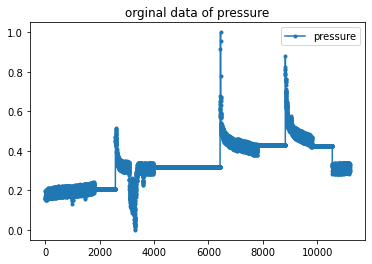

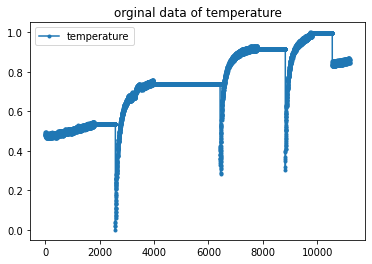

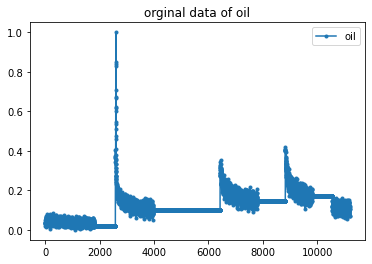

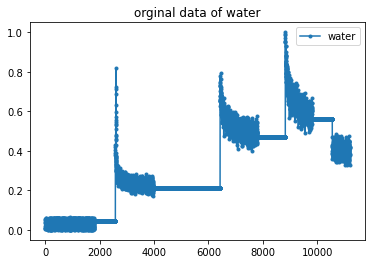

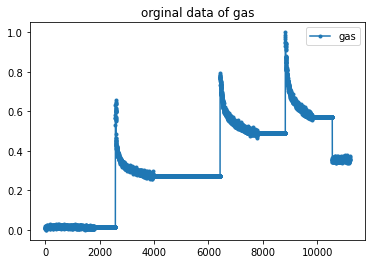

In [6]:
start  = 0
end = 11200
for i in ['pressure', 'temperature', 'oil', 'water', 'gas']:
    fig,ax = plt.subplots()
    ax.set_title('orginal data of %s'%i)
    ax.plot(df['time'].iloc[start:end], df[i].iloc[start:end], marker=".", label='%s'%i)
    ax.legend()

In [23]:
hyperpaprms_mult = {'input_shape':(300,2), 'nb_filters':64, 'kernel_size':3, 'dilations':(1, 2, 4, 8, 16, 32), 'dropout_rate':0.2}

In [24]:
model_gas_TCN_mult_wll = model_init(model='TCN', params=['past_readings', 'pressure readings'], \
                           hyperparamters=[hyperpaprms_mult, 5])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_2 (TCN)                  (None, 64)                136512    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 136,837
Trainable params: 136,837
Non-trainable params: 0
_________________________________________________________________


(456, 300, 2) (456, 5, 1)
Epoch 1/150
3/3 [==============================] - 3s 616ms/step - loss: 163.6008 - val_loss: 4.2705
Epoch 2/150
3/3 [==============================] - 1s 412ms/step - loss: 32.5696 - val_loss: 0.6726
Epoch 3/150
3/3 [==============================] - 1s 400ms/step - loss: 9.9322 - val_loss: 0.3179
Epoch 4/150
3/3 [==============================] - 1s 412ms/step - loss: 4.9747 - val_loss: 0.0990
Epoch 5/150
3/3 [==============================] - 1s 505ms/step - loss: 3.6281 - val_loss: 0.0774
Epoch 6/150
3/3 [==============================] - 1s 471ms/step - loss: 2.5045 - val_loss: 0.1404
Epoch 7/150
3/3 [==============================] - 1s 398ms/step - loss: 1.6442 - val_loss: 0.1938
Epoch 8/150
3/3 [==============================] - 1s 407ms/step - loss: 1.3193 - val_loss: 0.2377
Epoch 9/150
3/3 [==============================] - 1s 409ms/step - loss: 1.0742 - val_loss: 0.2563
Epoch 10/150
3/3 [==============================] - 1s 413ms/step - loss: 0.8441

3/3 [==============================] - 1s 424ms/step - loss: 0.1296 - val_loss: 0.0118
Epoch 83/150
3/3 [==============================] - 1s 419ms/step - loss: 0.1308 - val_loss: 0.0098
Epoch 84/150
3/3 [==============================] - 1s 425ms/step - loss: 0.1323 - val_loss: 0.0081
Epoch 85/150
3/3 [==============================] - 1s 404ms/step - loss: 0.1081 - val_loss: 0.0064
Epoch 86/150
3/3 [==============================] - 1s 432ms/step - loss: 0.0970 - val_loss: 0.0047
Epoch 87/150
3/3 [==============================] - 1s 404ms/step - loss: 0.1184 - val_loss: 0.0035
Epoch 88/150
3/3 [==============================] - 1s 420ms/step - loss: 0.1315 - val_loss: 0.0031
Epoch 89/150
3/3 [==============================] - 1s 405ms/step - loss: 0.0968 - val_loss: 0.0031
Epoch 90/150
3/3 [==============================] - 1s 423ms/step - loss: 0.1139 - val_loss: 0.0033
Epoch 91/150
3/3 [==============================] - 1s 633ms/step - loss: 0.1148 - val_loss: 0.0039
Epoch 92/150


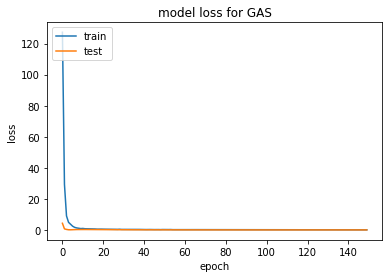

(711, 300, 2) (711, 5, 1)
Epoch 1/150
5/5 [==============================] - 2s 371ms/step - loss: 0.1930 - val_loss: 0.0440
Epoch 2/150
5/5 [==============================] - 2s 353ms/step - loss: 0.1748 - val_loss: 0.0246
Epoch 3/150
5/5 [==============================] - 2s 374ms/step - loss: 0.1399 - val_loss: 0.0083
Epoch 4/150
5/5 [==============================] - 2s 346ms/step - loss: 0.1153 - val_loss: 0.0043
Epoch 5/150
5/5 [==============================] - 1s 331ms/step - loss: 0.1193 - val_loss: 0.0054
Epoch 6/150
5/5 [==============================] - 2s 349ms/step - loss: 0.1269 - val_loss: 0.0040
Epoch 7/150
5/5 [==============================] - 2s 348ms/step - loss: 0.1151 - val_loss: 0.0032
Epoch 8/150
5/5 [==============================] - 2s 344ms/step - loss: 0.1089 - val_loss: 0.0015
Epoch 9/150
5/5 [==============================] - 2s 348ms/step - loss: 0.1007 - val_loss: 0.0026
Epoch 10/150
5/5 [==============================] - 2s 349ms/step - loss: 0.1030 - 

Epoch 83/150
5/5 [==============================] - 2s 352ms/step - loss: 0.0148 - val_loss: 0.0014
Epoch 84/150
5/5 [==============================] - 2s 349ms/step - loss: 0.0151 - val_loss: 0.0015
Epoch 85/150
5/5 [==============================] - 2s 340ms/step - loss: 0.0149 - val_loss: 0.0013
Epoch 86/150
5/5 [==============================] - 1s 331ms/step - loss: 0.0142 - val_loss: 0.0012
Epoch 87/150
5/5 [==============================] - 2s 354ms/step - loss: 0.0157 - val_loss: 0.0012
Epoch 88/150
5/5 [==============================] - 2s 335ms/step - loss: 0.0128 - val_loss: 0.0011
Epoch 89/150
5/5 [==============================] - 2s 371ms/step - loss: 0.0152 - val_loss: 9.0857e-04
Epoch 90/150
5/5 [==============================] - 2s 411ms/step - loss: 0.0132 - val_loss: 8.9077e-04
Epoch 91/150
5/5 [==============================] - 2s 338ms/step - loss: 0.0141 - val_loss: 9.8898e-04
Epoch 92/150
5/5 [==============================] - 2s 354ms/step - loss: 0.0138 - val_l

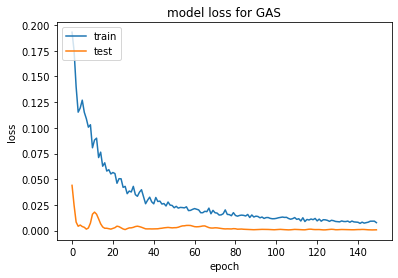

(420, 300, 2) (420, 5, 1)
Epoch 1/150
3/3 [==============================] - 1s 577ms/step - loss: 0.0484 - val_loss: 0.0122
Epoch 2/150
3/3 [==============================] - 1s 389ms/step - loss: 0.0310 - val_loss: 0.0025
Epoch 3/150
3/3 [==============================] - 1s 377ms/step - loss: 0.0223 - val_loss: 0.0056
Epoch 4/150
3/3 [==============================] - 1s 376ms/step - loss: 0.0239 - val_loss: 0.0087
Epoch 5/150
3/3 [==============================] - 1s 376ms/step - loss: 0.0220 - val_loss: 0.0051
Epoch 6/150
3/3 [==============================] - 1s 388ms/step - loss: 0.0266 - val_loss: 0.0017
Epoch 7/150
3/3 [==============================] - 1s 405ms/step - loss: 0.0199 - val_loss: 0.0013
Epoch 8/150
3/3 [==============================] - 1s 450ms/step - loss: 0.0206 - val_loss: 0.0015
Epoch 9/150
3/3 [==============================] - 1s 401ms/step - loss: 0.0184 - val_loss: 0.0019
Epoch 10/150
3/3 [==============================] - 1s 404ms/step - loss: 0.0207 - 

3/3 [==============================] - 1s 406ms/step - loss: 0.0145 - val_loss: 0.0014
Epoch 83/150
3/3 [==============================] - 1s 405ms/step - loss: 0.0107 - val_loss: 0.0025
Epoch 84/150
3/3 [==============================] - 1s 453ms/step - loss: 0.0099 - val_loss: 0.0032
Epoch 85/150
3/3 [==============================] - 1s 386ms/step - loss: 0.0098 - val_loss: 0.0035
Epoch 86/150
3/3 [==============================] - 1s 384ms/step - loss: 0.0095 - val_loss: 0.0029
Epoch 87/150
3/3 [==============================] - 1s 461ms/step - loss: 0.0090 - val_loss: 0.0020
Epoch 88/150
3/3 [==============================] - 1s 420ms/step - loss: 0.0088 - val_loss: 0.0019
Epoch 89/150
3/3 [==============================] - 1s 386ms/step - loss: 0.0080 - val_loss: 0.0018
Epoch 90/150
3/3 [==============================] - 1s 415ms/step - loss: 0.0099 - val_loss: 0.0016
Epoch 91/150
3/3 [==============================] - 1s 390ms/step - loss: 0.0097 - val_loss: 0.0018
Epoch 92/150


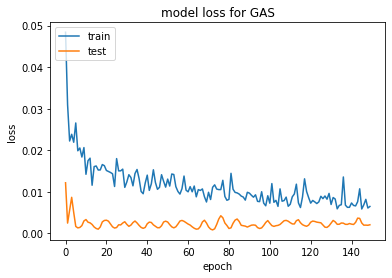

(286, 300, 2) (286, 5, 1)
Epoch 1/150
2/2 [==============================] - 1s 596ms/step - loss: 0.0130 - val_loss: 9.4334e-04
Epoch 2/150
2/2 [==============================] - 1s 556ms/step - loss: 0.0103 - val_loss: 0.0017
Epoch 3/150
2/2 [==============================] - 1s 528ms/step - loss: 0.0059 - val_loss: 0.0034
Epoch 4/150
2/2 [==============================] - 1s 483ms/step - loss: 0.0078 - val_loss: 0.0054
Epoch 5/150
2/2 [==============================] - 1s 573ms/step - loss: 0.0091 - val_loss: 0.0062
Epoch 6/150
2/2 [==============================] - 1s 474ms/step - loss: 0.0104 - val_loss: 0.0054
Epoch 7/150
2/2 [==============================] - 1s 492ms/step - loss: 0.0078 - val_loss: 0.0040
Epoch 8/150
2/2 [==============================] - 1s 481ms/step - loss: 0.0082 - val_loss: 0.0027
Epoch 9/150
2/2 [==============================] - 1s 487ms/step - loss: 0.0088 - val_loss: 0.0021
Epoch 10/150
2/2 [==============================] - 1s 467ms/step - loss: 0.009

2/2 [==============================] - 1s 507ms/step - loss: 0.0068 - val_loss: 0.0032
Epoch 83/150
2/2 [==============================] - 1s 597ms/step - loss: 0.0102 - val_loss: 0.0035
Epoch 84/150
2/2 [==============================] - 1s 483ms/step - loss: 0.0063 - val_loss: 0.0034
Epoch 85/150
2/2 [==============================] - 1s 482ms/step - loss: 0.0060 - val_loss: 0.0036
Epoch 86/150
2/2 [==============================] - 1s 475ms/step - loss: 0.0115 - val_loss: 0.0036
Epoch 87/150
2/2 [==============================] - 1s 478ms/step - loss: 0.0085 - val_loss: 0.0037
Epoch 88/150
2/2 [==============================] - 1s 478ms/step - loss: 0.0084 - val_loss: 0.0040
Epoch 89/150
2/2 [==============================] - 1s 495ms/step - loss: 0.0078 - val_loss: 0.0043
Epoch 90/150
2/2 [==============================] - 1s 502ms/step - loss: 0.0069 - val_loss: 0.0044
Epoch 91/150
2/2 [==============================] - 1s 488ms/step - loss: 0.0105 - val_loss: 0.0045
Epoch 92/150


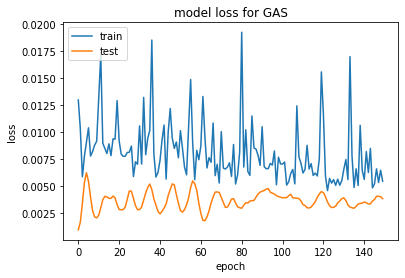

(141, 300, 2) (141, 5, 1)
Epoch 1/150
1/1 [==============================] - 0s 440ms/step - loss: 0.0651 - val_loss: 0.0440
Epoch 2/150
1/1 [==============================] - 0s 359ms/step - loss: 0.0597 - val_loss: 0.0325
Epoch 3/150
1/1 [==============================] - 0s 343ms/step - loss: 0.0385 - val_loss: 0.0214
Epoch 4/150
1/1 [==============================] - 0s 341ms/step - loss: 0.0300 - val_loss: 0.0129
Epoch 5/150
1/1 [==============================] - 0s 335ms/step - loss: 0.0201 - val_loss: 0.0077
Epoch 6/150
1/1 [==============================] - 0s 357ms/step - loss: 0.0121 - val_loss: 0.0040
Epoch 7/150
1/1 [==============================] - 0s 373ms/step - loss: 0.0094 - val_loss: 0.0020
Epoch 8/150
1/1 [==============================] - 0s 354ms/step - loss: 0.0074 - val_loss: 0.0012
Epoch 9/150
1/1 [==============================] - 0s 348ms/step - loss: 0.0079 - val_loss: 0.0013
Epoch 10/150
1/1 [==============================] - 0s 449ms/step - loss: 0.0070 - 

1/1 [==============================] - 0s 355ms/step - loss: 0.0039 - val_loss: 2.7249e-04
Epoch 81/150
1/1 [==============================] - 0s 360ms/step - loss: 0.0026 - val_loss: 2.6393e-04
Epoch 82/150
1/1 [==============================] - 0s 359ms/step - loss: 0.0032 - val_loss: 2.5329e-04
Epoch 83/150
1/1 [==============================] - 0s 332ms/step - loss: 0.0018 - val_loss: 2.4809e-04
Epoch 84/150
1/1 [==============================] - 0s 329ms/step - loss: 0.0020 - val_loss: 2.4716e-04
Epoch 85/150
1/1 [==============================] - 0s 338ms/step - loss: 0.0066 - val_loss: 2.4943e-04
Epoch 86/150
1/1 [==============================] - 0s 343ms/step - loss: 0.0024 - val_loss: 2.5306e-04
Epoch 87/150
1/1 [==============================] - 0s 341ms/step - loss: 0.0026 - val_loss: 2.5804e-04
Epoch 88/150
1/1 [==============================] - 0s 454ms/step - loss: 0.0036 - val_loss: 2.6014e-04
Epoch 89/150
1/1 [==============================] - 0s 346ms/step - loss: 0.0

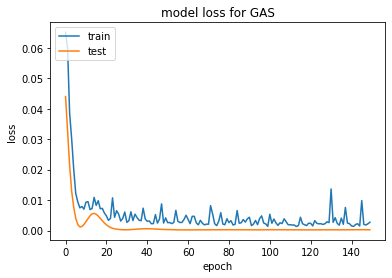

In [25]:

splits = [0, 2579, 6432, 8832, 10560]
k = 0
ep = 150
evaluation_interval = 10
for i in range(5):
    k += 1
    # print(i)
    # print(sumF)
    if k == 5:
      x, y = multivariate_data(np.array(train_mult_gas), splits[i],splits[i]+1000, 300, 5, column_index=2)
      x = x.astype(np.float32)
      y = y.astype(np.float32)
    else: 
      x, y = multivariate_data(np.array(train_mult_gas), splits[i], splits[i+1]-1, 300, 5, column_index=2)
      x = x.astype(np.float32)
      y = y.astype(np.float32)
    print(x.shape, y.shape)
    # sumF+=i
    history_gas_uni_pressure = model_gas_TCN_mult_wll.fit(x, y, epochs=ep, validation_split=0.8)
    print('++++++++++++++++++++++')
    print(k)
    print('++++++++++++++++++++++')
    plt.plot(history_gas_uni_pressure.history['loss'])
    plt.plot(history_gas_uni_pressure.history['val_loss'])
    plt.title('model loss for GAS')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

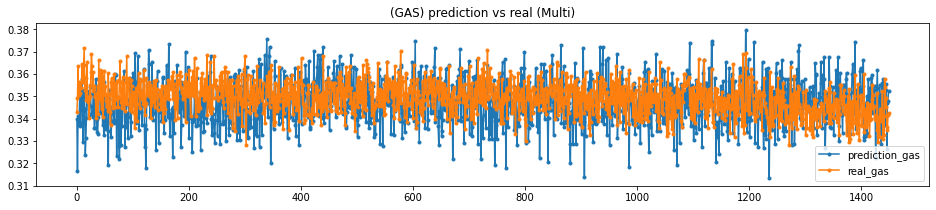

In [26]:
gas_mult_testX_well, gas_mult_testY_well = multivariate_data(np.array(train_mult_gas),11200, len(df)-10, 300, 5, column_index=2)
gas_mult_testX_well = gas_mult_testX_well.astype(np.float32)
gas_mult_testY_well = gas_mult_testY_well.astype(np.float32)
real_gas_mult_well = gas_mult_testY_well.flatten()
pred_gas_mult_well = model_gas_TCN_mult_wll.predict(gas_mult_testX_well).flatten()
df_plot_gas_mult_well=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_gas_mult_well, real_gas_mult_well]))))
df_plot_gas_mult_well['ds']=range(0,len(real_gas_mult_well))
start = 0
end = len(df_plot_gas_mult_well)
fig,ax = plt.subplots(figsize=(16,3))
ax.set_title('(GAS) prediction vs real (Multi)')
ax.plot(df_plot_gas_mult_well['ds'].iloc[start:end], df_plot_gas_mult_well['prediction'].iloc[start:end], marker=".", label='prediction_gas')
ax.plot(df_plot_gas_mult_well['ds'].iloc[start:end], df_plot_gas_mult_well['real'].iloc[start:end], marker=".", label='real_gas')
ax.legend()

##### Model parameters and structure:

In [4]:
# Univariate & Multivariate - OIL 
model_oil_TCN_uni = model_init(model='TCN', params=['past_readings'], \
                           hyperparamters=[{'input_shape':(300,1), 'nb_filters':128, 'kernel_size':5, 'dilations':(1, 2, 4, 8, 16, 32, 64)}, 5])
model_oil_TCN_mult = model_init(model='TCN', params=['past_readings', 'pressure readings'], \
                           hyperparamters=[{'input_shape':(300,3), 'nb_filters':32, 'kernel_size':4, 'dilations':(1, 2, 4, 4, 4)}, 5])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 128)               1067648   
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 1,068,293
Trainable params: 1,068,293
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_1 (TCN)                  (None, 32)                37696     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 37,861
Trainable params: 37,861
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Univariate & Multivariate - WATER 
model_water_TCN_uni = model_init(model='TCN', params=['past_readings'], \
                           hyperparamters=[{'input_shape':(300,1), 'nb_filters':128, 'kernel_size':5, 'dilations':(1, 2, 4, 4, 8, 16, 32, 64)}, 5])
model_water_TCN_mult = model_init(model='TCN', params=['past_readings', 'pressure readings'], \
                           hyperparamters=[{'input_shape':(300,3), 'nb_filters':32, 'kernel_size':4, 'dilations':(1, 2, 4, 8, 16)}, 5])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_2 (TCN)                  (None, 128)               1231744   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 1,232,389
Trainable params: 1,232,389
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_3 (TCN)                  (None, 32)                37696     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 165       
Total params: 37,861
Trainable params: 37,861
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Univariate & Multivariate - GAS 
model_gas_TCN_uni_wll = model_init(model='TCN', params=['past_readings'], \
                           hyperparamters=[{'input_shape':(300,1), 'nb_filters':256, 'kernel_size':5, 'dilations':(1, 2, 4, 8, 16, 32, 64, 128)}, 5])
model_gas_TCN_mult_wll = model_init(model='TCN', params=['past_readings', 'pressure readings'], \
                           hyperparamters=[{'input_shape':(300,3), 'nb_filters':32, 'kernel_size':4, 'dilations':(1, 2, 4, 8, 16)}, 5])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_4 (TCN)                  (None, 256)               4921088   
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1285      
Total params: 4,922,373
Trainable params: 4,922,373
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_5 (TCN)                  (None, 32)                37696     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 165       
Total params: 37,861
Trainable params: 37,861
Non-trainable params: 0
_________________________________________________________________


In [8]:
lengths = [len(i) for i in fp]
indexs = [i+k for i in zip(lengths, )]

[1797, 1394, 1366, 978, 2398]

#### Data configuration:

In [29]:
## Oil
oil_uni_train, oil_uni_val, oil_uni_testX, oil_uni_testY = configure(train_uni_oil, \
                                                                     params = [0, 4557, 4557, 5535,5535, 7910], multi = False, column_index=3)
oil_mult_train, oil_mult_val, oil_mult_testX, oil_mult_testY = configure(train_mult_oil,\
                                                                     params = [0, 4557, 4557, 5535,5535, 7910], multi = True, column_index=2)

# # # Water 
water_uni_train, water_uni_val, water_uni_testX, water_uni_testY = configure(train_uni_water, \
                                                                     params = [0, 4557, 4557, 5535,5535, 7910], multi = False, column_index=3)
water_mult_train, water_mult_val, water_mult_testX, water_mult_testY = configure(train_mult_water,\
                                                                     params = [0, 4557, 4557, 5535,5535, 7910], multi = True, column_index=2)
# Gas
# Water 
gas_uni_train_well, gas_uni_val_well, gas_uni_testX_well, gas_uni_testY_well = configure(train_uni_gas, \
                                                                     params = [0, 4557, 4557, 5535,5535, 7910], multi = False)
gas_mult_train_well, gas_mult_val_well, gas_mult_testX_well, gas_mult_testY_well = configure(train_mult_gas,\
                                                                         params = [0, 4557, 4557, 5535,5535, 7910], multi = True, column_index=2)

(852, 300, 3) (852, 5, 1) (136, 300, 3) (136, 5, 1) (416, 300, 3) (416, 5, 1)
(852, 300, 3) (852, 5, 1) (136, 300, 3) (136, 5, 1) (416, 300, 3) (416, 5, 1)
(852, 300, 3) (852, 5, 1) (136, 300, 3) (136, 5, 1) (416, 300, 3) (416, 5, 1)
(852, 300, 3) (852, 5, 1) (136, 300, 3) (136, 5, 1) (416, 300, 3) (416, 5, 1)
(852, 300, 3) (852, 5, 1) (136, 300, 3) (136, 5, 1) (416, 300, 3) (416, 5, 1)
(852, 300, 3) (852, 5, 1) (136, 300, 3) (136, 5, 1) (416, 300, 3) (416, 5, 1)


Epoch 1/20
5/5 [==============================] - 10s 2s/step - loss: 0.3055 - val_loss: 0.0229
Epoch 2/20
5/5 [==============================] - 10s 2s/step - loss: 0.0209 - val_loss: 0.0172
Epoch 3/20
5/5 [==============================] - 9s 2s/step - loss: 0.0122 - val_loss: 0.0037
Epoch 4/20
5/5 [==============================] - 11s 2s/step - loss: 0.0051 - val_loss: 0.0022
Epoch 5/20
5/5 [==============================] - 10s 2s/step - loss: 0.0033 - val_loss: 0.0028
Epoch 6/20
5/5 [==============================] - 9s 2s/step - loss: 0.0024 - val_loss: 0.0023
Epoch 7/20
5/5 [==============================] - 10s 2s/step - loss: 0.0019 - val_loss: 0.0020
Epoch 8/20
5/5 [==============================] - 9s 2s/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/20
5/5 [==============================] - 9s 2s/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/20
5/5 [==============================] - 9s 2s/step - loss: 8.6844e-04 - val_loss: 0.0010
Epoch 11/20
5/5 [=======================

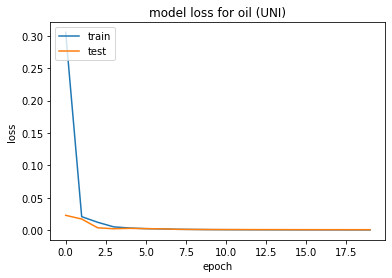

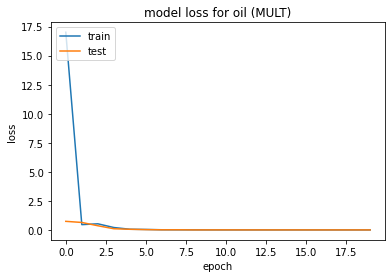

Epoch 1/20
5/5 [==============================] - 8s 1s/step - loss: 3.9827e-04 - val_loss: 7.3881e-04
Epoch 2/20
5/5 [==============================] - 6s 1s/step - loss: 3.8105e-04 - val_loss: 7.3711e-04
Epoch 3/20
5/5 [==============================] - 7s 1s/step - loss: 3.5758e-04 - val_loss: 7.2464e-04
Epoch 4/20
5/5 [==============================] - 6s 1s/step - loss: 3.2912e-04 - val_loss: 7.2355e-04
Epoch 5/20
5/5 [==============================] - 8s 2s/step - loss: 3.1193e-04 - val_loss: 7.1709e-04
Epoch 6/20
5/5 [==============================] - 7s 2s/step - loss: 2.8292e-04 - val_loss: 7.1652e-04
Epoch 7/20
5/5 [==============================] - 7s 1s/step - loss: 2.7843e-04 - val_loss: 7.0839e-04
Epoch 8/20
5/5 [==============================] - 6s 1s/step - loss: 2.4570e-04 - val_loss: 7.0550e-04
Epoch 9/20
5/5 [==============================] - 7s 1s/step - loss: 2.4532e-04 - val_loss: 7.0018e-04
Epoch 10/20
5/5 [==============================] - 6s 2s/step - loss: 2.1

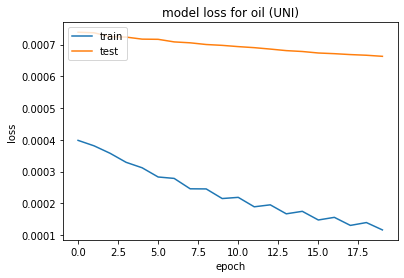

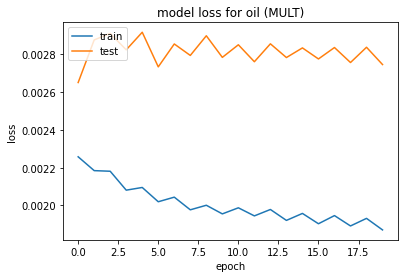

Epoch 1/20
5/5 [==============================] - 6s 1s/step - loss: 1.2840e-04 - val_loss: 6.3203e-04
Epoch 2/20
5/5 [==============================] - 5s 1s/step - loss: 1.0889e-04 - val_loss: 6.3270e-04
Epoch 3/20
5/5 [==============================] - 6s 1s/step - loss: 1.1472e-04 - val_loss: 6.2968e-04
Epoch 4/20
5/5 [==============================] - 5s 1s/step - loss: 9.6799e-05 - val_loss: 6.3301e-04
Epoch 5/20
5/5 [==============================] - 6s 1s/step - loss: 1.0260e-04 - val_loss: 6.2974e-04
Epoch 6/20
5/5 [==============================] - 5s 1s/step - loss: 8.5918e-05 - val_loss: 6.3094e-04
Epoch 7/20
5/5 [==============================] - 6s 1s/step - loss: 9.0955e-05 - val_loss: 6.2883e-04
Epoch 8/20
5/5 [==============================] - 5s 1s/step - loss: 7.5937e-05 - val_loss: 6.2916e-04
Epoch 9/20
5/5 [==============================] - 6s 1s/step - loss: 8.0854e-05 - val_loss: 6.2797e-04
Epoch 10/20
5/5 [==============================] - 8s 2s/step - loss: 6.7

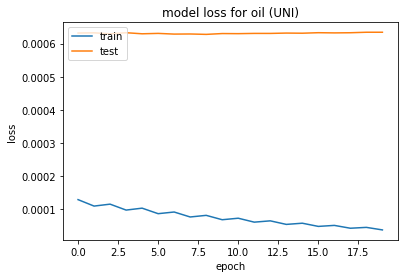

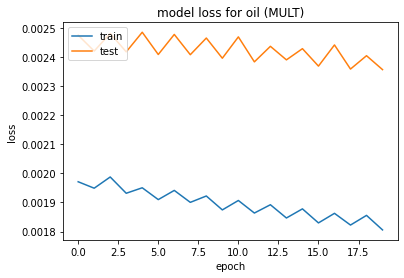

Epoch 1/20
5/5 [==============================] - 7s 2s/step - loss: 3.5751e-05 - val_loss: 4.7173e-04
Epoch 2/20
5/5 [==============================] - 6s 1s/step - loss: 2.7130e-05 - val_loss: 4.7176e-04
Epoch 3/20
5/5 [==============================] - 6s 1s/step - loss: 1.9130e-05 - val_loss: 4.7568e-04
Epoch 4/20
5/5 [==============================] - 7s 1s/step - loss: 1.2851e-05 - val_loss: 4.7445e-04
Epoch 5/20
5/5 [==============================] - 6s 1s/step - loss: 8.4477e-06 - val_loss: 4.7888e-04
Epoch 6/20
5/5 [==============================] - 6s 1s/step - loss: 5.5416e-06 - val_loss: 4.7851e-04
Epoch 7/20
5/5 [==============================] - 6s 1s/step - loss: 3.6701e-06 - val_loss: 4.7828e-04
Epoch 8/20
5/5 [==============================] - 6s 1s/step - loss: 2.4778e-06 - val_loss: 4.7922e-04
Epoch 9/20
5/5 [==============================] - 6s 1s/step - loss: 1.6771e-06 - val_loss: 4.7829e-04
Epoch 10/20
5/5 [==============================] - 7s 1s/step - loss: 1.1

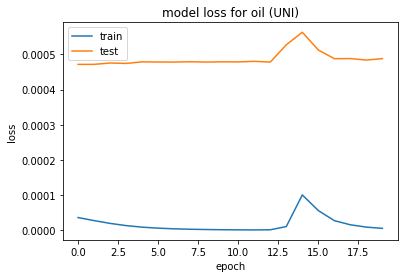

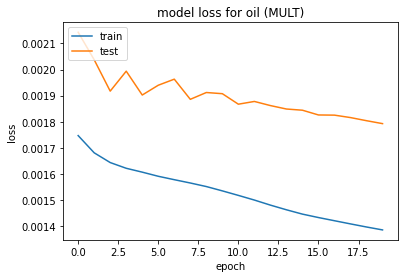

In [11]:
sumF = 0
k = 0
for i in fp[:4]:
    k += 1
    oil_uni_train, oil_uni_val, oil_uni_testX, oil_uni_testY = configure(train_uni_oil, \
                                                                     params = [sumF, sumF+int(0.5*len(i)), sumF+int(0.5*len(i)), sumF+len(i),sumF+int(0.5*len(i)), sumF+len(i)], multi = False, column_index=3)
#     model_trained_oil_uni= model_train(oil_uni_train, 'Qo (m3/day)', model_oil_TCN_uni,\
#                                       'TCN', [20, 5], oil_uni_val)
    oil_mult_train, oil_mult_val, oil_mult_testX, oil_mult_testY = configure(train_mult_oil,\
                                                                     params = [sumF, sumF+int(0.5*len(i)), sumF+int(0.5*len(i)), sumF+len(i),sumF+int(0.5*len(i)), sumF+len(i)], multi = True, column_index=2)
#     model_trained_oil_mult= model_train(oil_mult_train, 'Qo (m3/day)', model_oil_TCN_mult,\
#                                       'TCN', [20, 5], oil_mult_val)
    print('++++++++++++++++++++++')
    print(k)
    print('++++++++++++++++++++++')
    plt.plot(model_trained_oil_uni.history['loss'])
    plt.plot(model_trained_oil_uni.history['val_loss'])
    plt.title('model loss for oil (UNI)')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.plot(model_trained_oil_mult.history['loss'])
    plt.plot(model_trained_oil_mult.history['val_loss'])
    plt.title('model loss for oil (MULT)')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    

Epoch 1/20
5/5 [==============================] - 15s 2s/step - loss: 2.8331 - val_loss: 0.0389
Epoch 2/20
5/5 [==============================] - 10s 2s/step - loss: 0.0364 - val_loss: 0.0372
Epoch 3/20
5/5 [==============================] - 10s 2s/step - loss: 0.0265 - val_loss: 0.0103
Epoch 4/20
5/5 [==============================] - 9s 2s/step - loss: 0.0089 - val_loss: 0.0047
Epoch 5/20
5/5 [==============================] - 10s 2s/step - loss: 0.0058 - val_loss: 0.0050
Epoch 6/20
5/5 [==============================] - 10s 2s/step - loss: 0.0047 - val_loss: 0.0049
Epoch 7/20
5/5 [==============================] - 10s 2s/step - loss: 0.0035 - val_loss: 0.0039
Epoch 8/20
5/5 [==============================] - 10s 2s/step - loss: 0.0027 - val_loss: 0.0036
Epoch 9/20
5/5 [==============================] - 10s 2s/step - loss: 0.0020 - val_loss: 0.0028
Epoch 10/20
5/5 [==============================] - 10s 2s/step - loss: 0.0015 - val_loss: 0.0026
Epoch 11/20
5/5 [=======================

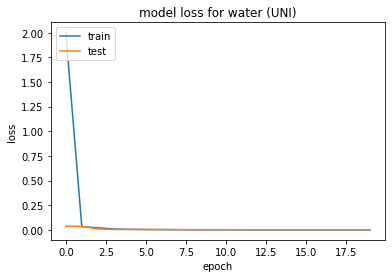

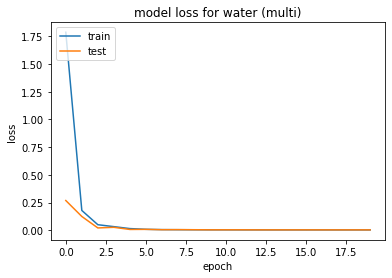

Epoch 1/20
5/5 [==============================] - 7s 1s/step - loss: 2.7185e-04 - val_loss: 0.0021
Epoch 2/20
5/5 [==============================] - 6s 1s/step - loss: 2.1673e-04 - val_loss: 0.0021
Epoch 3/20
5/5 [==============================] - 7s 1s/step - loss: 2.0599e-04 - val_loss: 0.0021
Epoch 4/20
5/5 [==============================] - 6s 1s/step - loss: 1.5401e-04 - val_loss: 0.0021
Epoch 5/20
5/5 [==============================] - 10s 2s/step - loss: 1.4729e-04 - val_loss: 0.0021
Epoch 6/20
5/5 [==============================] - 9s 2s/step - loss: 1.0448e-04 - val_loss: 0.0020
Epoch 7/20
5/5 [==============================] - 13s 2s/step - loss: 9.9429e-05 - val_loss: 0.0020
Epoch 8/20
5/5 [==============================] - 13s 3s/step - loss: 7.1096e-05 - val_loss: 0.0020
Epoch 9/20
5/5 [==============================] - 13s 2s/step - loss: 6.9487e-05 - val_loss: 0.0020
Epoch 10/20
5/5 [==============================] - 8s 2s/step - loss: 5.0104e-05 - val_loss: 0.0020
Epoch

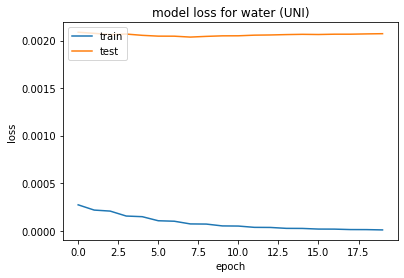

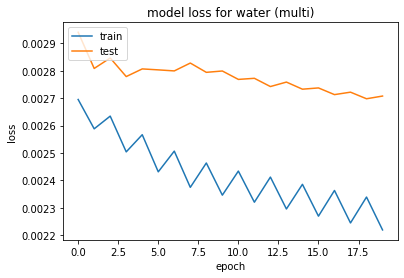

Epoch 1/20
5/5 [==============================] - 11s 2s/step - loss: 7.9936e-06 - val_loss: 0.0022
Epoch 2/20
5/5 [==============================] - 7s 2s/step - loss: 6.0161e-06 - val_loss: 0.0022
Epoch 3/20
5/5 [==============================] - 8s 2s/step - loss: 7.2196e-06 - val_loss: 0.0022
Epoch 4/20
5/5 [==============================] - 6s 1s/step - loss: 1.0041e-05 - val_loss: 0.0022
Epoch 5/20
5/5 [==============================] - 8s 1s/step - loss: 4.4993e-05 - val_loss: 0.0023
Epoch 6/20
5/5 [==============================] - 6s 2s/step - loss: 9.8426e-05 - val_loss: 0.0024
Epoch 7/20
5/5 [==============================] - 9s 2s/step - loss: 1.4318e-04 - val_loss: 0.0022
Epoch 8/20
5/5 [==============================] - 6s 1s/step - loss: 2.2453e-05 - val_loss: 0.0022
Epoch 9/20
5/5 [==============================] - 9s 2s/step - loss: 3.6656e-05 - val_loss: 0.0022
Epoch 10/20
5/5 [==============================] - 8s 2s/step - loss: 1.6832e-05 - val_loss: 0.0022
Epoch 11

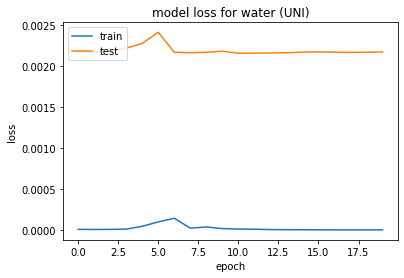

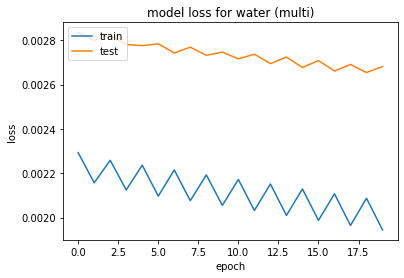

In [9]:
sumF = 0
k = 0
for i in fp[:3]:
    water_uni_train, water_uni_val, water_uni_testX, water_uni_testY = configure(train_uni_water, \
                                                                     params = [sumF, sumF+int(0.5*len(i)), sumF+int(0.5*len(i)), sumF+len(i),sumF+int(0.5*len(i)), sumF+len(i)], multi = False, column_index=3)
    model_trained_water_uni= model_train(water_uni_train, 'Qw (m3/day)', model_water_TCN_uni,\
                                      'TCN', [20, 5], water_uni_val)
    water_mult_train, water_mult_val, water_mult_testX, water_mult_testY = configure(train_mult_water,\
                                                                     params = [sumF, sumF+int(0.5*len(i)), sumF+int(0.5*len(i)), sumF+len(i), sumF+int(0.5*len(i)), sumF+len(i)], multi = True, column_index=2)
    model_trained_water_mult= model_train(water_mult_train, 'Qw (m3/day)', model_water_TCN_mult,\
                                      'TCN', [20, 5], water_mult_val)
    k += 1
    print('++++++++++++++++++++++')
    print(k)
    print('++++++++++++++++++++++')
    # WATER
    plt.plot(model_trained_water_uni.history['loss'])
    plt.plot(model_trained_water_uni.history['val_loss'])
    plt.title('model loss for water (UNI)')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.plot(model_trained_water_mult.history['loss'])
    plt.plot(model_trained_water_mult.history['val_loss'])
    plt.title('model loss for water (multi)')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [10]:
s =0
for i in fp:
    print(len(i))
    s+= len(i)
    print(s)

1797
1797
1394
3191
1366
4557
978
5535
2398
7933


In [21]:
water_uni_train, water_uni_val, water_uni_testX, water_uni_testY = configure(train_uni_water, \
                                                                     params = [0, 1000, 1000, 2000, 4557, 5545 ], multi = False, column_index=3)
    
water_mult_train, water_mult_val, water_mult_testX, water_mult_testY = configure(train_mult_water,\
                                                                 params = [0, 1000, 1000, 2000, 4557, 5545 ], multi = True, column_index=2)

(141, 300, 3) (141, 5, 1) (141, 300, 3) (141, 5, 1) (138, 300, 3) (138, 5, 1)
(141, 300, 3) (141, 5, 1) (141, 300, 3) (141, 5, 1) (138, 300, 3) (138, 5, 1)


In [22]:
water_uni_testY.flatten().shape

(685,)

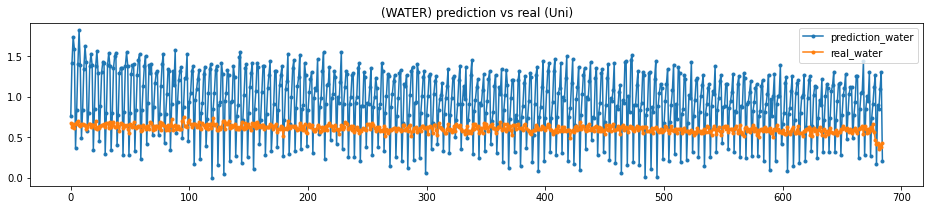

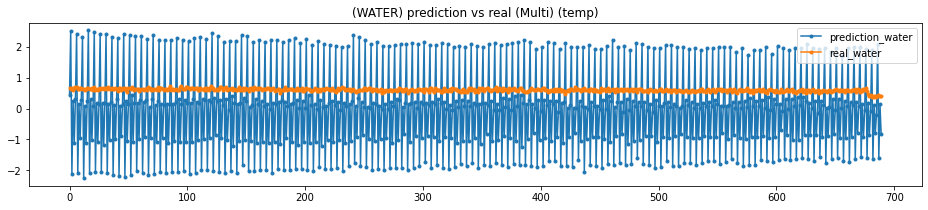

In [23]:
# univariate
real_water_uni = water_uni_testY.flatten()
pred_water_uni = model_water_TCN_uni.predict(water_uni_testX).flatten()
df_plot_water_uni=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([ pred_water_uni, real_water_uni]))))
df_plot_water_uni['ds']=range(0,len(real_water_uni))
## multivariate 
real_water_mult = water_mult_testY.flatten()
pred_water_mult = model_water_TCN_mult.predict(water_mult_testX).flatten()
df_plot_water_mult=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([ pred_water_mult, real_water_mult]))))
df_plot_water_mult['ds']=range(0,len(real_water_mult))
start = 0
end = 1000
fig,ax = plt.subplots(figsize=(16,3))
ax.set_title('(WATER) prediction vs real (Uni)')
ax.plot(df_plot_water_uni['ds'].iloc[start:end], df_plot_water_uni['prediction'].iloc[start:end], marker=".", label='prediction_water')
ax.plot(df_plot_water_uni['ds'].iloc[start:end], df_plot_water_uni['real'].iloc[start:end], marker=".", label='real_water')
ax.legend()
fig,ax = plt.subplots(figsize=(16,3))
ax.set_title('(WATER) prediction vs real (Multi) (temp)')
ax.plot(df_plot_water_mult['ds'].iloc[start:end], df_plot_water_mult['prediction'].iloc[start:end], marker=".", label='prediction_water')
ax.plot(df_plot_water_mult['ds'].iloc[start:end], df_plot_water_mult['real'].iloc[start:end], marker=".", label='real_water')
ax.legend()

In [ ]:
sumF = 0
k = 0
for i in fp[:2]:
    k+=1
    gas_uni_train_well, gas_uni_val_well, gas_uni_testX_well, gas_uni_testY_well = configure(train_uni_gas, \
                                                                     params = [sumF, sumF+int(0.5*len(i)), sumF+int(0.5*len(i)), sumF+len(i), sumF+int(0.5*len(i)), sumF+len(i)], multi = False)
    model_trained_gas_uni_wll= model_train(gas_uni_train_well, 'Qg (m3/day)', model_gas_TCN_uni_wll,\
                                      'TCN', [30, 5], gas_uni_val_well)
    gas_mult_train_well, gas_mult_val_well, gas_mult_testX_well, gas_mult_testY_well = configure(train_mult_gas,\
                                                                         params = [sumF, sumF+int(0.5*len(i)), sumF+int(0.5*len(i)), sumF+len(i), sumF+int(0.5*len(i)), sumF+len(i)], multi = True, column_index=2)
    model_trained_gas_mult_wll= model_train(gas_mult_train_well, 'Qg (m3/day)', model_gas_TCN_mult_wll,\
                                      'TCN', [30, 5], gas_mult_val_well)
    k += 1
    print('++++++++++++++++++++++')
    print(k)
    print('++++++++++++++++++++++')
    # GAS
    plt.plot(model_trained_gas_uni_wll.history['loss'])
    plt.plot(model_trained_gas_uni_wll.history['val_loss'])
    plt.title('model loss for water (UNI)')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.plot(model_trained_gas_mult_wll.history['loss'])
    plt.plot(model_trained_gas_mult_wll.history['val_loss'])
    plt.title('model loss for water (multi)')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
#     real_gas_uni_well = gas_uni_testY_well.flatten()
#     pred_gas_uni_well = model_gas_TCN_uni_wll.predict(gas_uni_testX_well).flatten()
#     df_plot_gas_uni_well=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_gas_uni_well, real_gas_uni_well]))))
#     df_plot_gas_uni_well['ds']=range(0,len(real_gas_uni_well))
#     ### multivariate 
#     real_gas_mult_well = gas_mult_testY_well.flatten()
#     pred_gas_mult_well = model_gas_TCN_mult_wll.predict(gas_mult_testX_well).flatten()
#     df_plot_gas_mult_well=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_gas_mult_well, real_gas_mult_well]))))
#     df_plot_gas_mult_well['ds']=range(0,len(real_gas_mult_well))
#     start = 0
#     end = len(df_plot_gas_uni_well)
#     fig,ax = plt.subplots(figsize=(16,3))
#     ax.set_title('(GAS) prediction vs real (Uni) %s'%k)
#     ax.plot(df_plot_gas_uni_well['ds'].iloc[start:end], df_plot_gas_uni_well['prediction'].iloc[start:end], marker=".", label='prediction_gas')
#     ax.plot(df_plot_gas_uni_well['ds'].iloc[start:end], df_plot_gas_uni_well['real'].iloc[start:end], marker=".", label='real_gas')
#     ax.legend()
#     fig,ax = plt.subplots(figsize=(16,3))
#     ax.set_title('(GAS) prediction vs real (Multi)%s'%k)
#     ax.plot(df_plot_gas_mult_well['ds'].iloc[start:end], df_plot_gas_mult_well['prediction'].iloc[start:end], marker=".", label='prediction_gas')
#     ax.plot(df_plot_gas_mult_well['ds'].iloc[start:end], df_plot_gas_mult_well['real'].iloc[start:end], marker=".", label='real_gas')
#     ax.legend()

Epoch 1/30


In [25]:
## gas testing data set visualization
### univariate 
real_gas_uni_well = gas_uni_testY_well.flatten()
pred_gas_uni_well = model_gas_TCN_uni_wll.predict(gas_uni_testX_well).flatten()
df_plot_gas_uni_well=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_gas_uni_well, real_gas_uni_well]))))
df_plot_gas_uni_well['ds']=range(0,len(real_gas_uni_well))
### multivariate 
real_gas_mult_well = gas_mult_testY_well.flatten()
pred_gas_mult_well = model_gas_TCN_mult_wll.predict(gas_mult_testX_well).flatten()
df_plot_gas_mult_well=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_gas_mult_well, real_gas_mult_well]))))
df_plot_gas_mult_well['ds']=range(0,len(real_gas_mult_well))

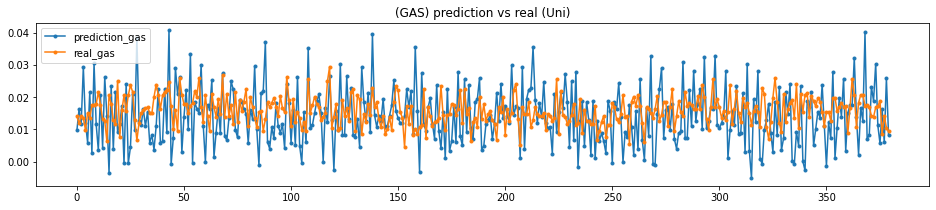

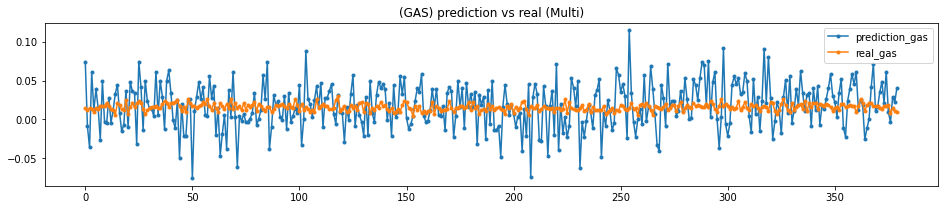

In [26]:
### GAS
start = 0
end = len(df_plot_gas_uni_well)
fig,ax = plt.subplots(figsize=(16,3))
ax.set_title('(GAS) prediction vs real (Uni)')
ax.plot(df_plot_gas_uni_well['ds'].iloc[start:end], df_plot_gas_uni_well['prediction'].iloc[start:end], marker=".", label='prediction_gas')
ax.plot(df_plot_gas_uni_well['ds'].iloc[start:end], df_plot_gas_uni_well['real'].iloc[start:end], marker=".", label='real_gas')
ax.legend()
fig,ax = plt.subplots(figsize=(16,3))
ax.set_title('(GAS) prediction vs real (Multi)')
ax.plot(df_plot_gas_mult_well['ds'].iloc[start:end], df_plot_gas_mult_well['prediction'].iloc[start:end], marker=".", label='prediction_gas')
ax.plot(df_plot_gas_mult_well['ds'].iloc[start:end], df_plot_gas_mult_well['real'].iloc[start:end], marker=".", label='real_gas')
ax.legend()

In [43]:
# Univariate - OIL 
model_trained_oil_uni= model_train(oil_uni_train, 'Qo (m3/day)', model_oil_TCN_uni,\
                                      'TCN', [50, 10], oil_uni_val)

Epoch 1/50
10/10 [==============================] - 18s 2s/step - loss: 0.0019 - val_loss: 0.0041
Epoch 2/50
10/10 [==============================] - 15s 2s/step - loss: 0.0014 - val_loss: 0.0116
Epoch 3/50
10/10 [==============================] - 16s 2s/step - loss: 0.0017 - val_loss: 0.0024
Epoch 4/50
10/10 [==============================] - 16s 2s/step - loss: 0.0018 - val_loss: 0.0032
Epoch 5/50
10/10 [==============================] - 16s 2s/step - loss: 0.0016 - val_loss: 0.0057
Epoch 6/50
10/10 [==============================] - 15s 2s/step - loss: 0.0014 - val_loss: 0.0034
Epoch 7/50
10/10 [==============================] - 16s 2s/step - loss: 0.0021 - val_loss: 0.0034
Epoch 8/50
10/10 [==============================] - 16s 2s/step - loss: 0.0016 - val_loss: 0.0033
Epoch 9/50
10/10 [==============================] - 15s 2s/step - loss: 0.0016 - val_loss: 0.0045
Epoch 10/50
10/10 [==============================] - 16s 2s/step - loss: 0.0013 - val_loss: 0.0047
Epoch 11/50
10/10 [

In [44]:
# Multivariate - OIL 
model_trained_oil_mult= model_train(oil_mult_train, 'Qo (m3/day)', model_oil_TCN_mult,\
                                      'TCN', [50, 10], oil_mult_val)

Epoch 1/50
10/10 [==============================] - 2s 163ms/step - loss: 0.0069 - val_loss: 0.0051
Epoch 2/50
10/10 [==============================] - 1s 148ms/step - loss: 0.0048 - val_loss: 0.0253
Epoch 3/50
10/10 [==============================] - 1s 145ms/step - loss: 0.0074 - val_loss: 0.0043
Epoch 4/50
10/10 [==============================] - 2s 155ms/step - loss: 0.0078 - val_loss: 0.0107
Epoch 5/50
10/10 [==============================] - 2s 167ms/step - loss: 0.0077 - val_loss: 0.0242
Epoch 6/50
10/10 [==============================] - 2s 167ms/step - loss: 0.0068 - val_loss: 0.0111
Epoch 7/50
10/10 [==============================] - 2s 161ms/step - loss: 0.0077 - val_loss: 0.0096
Epoch 8/50
10/10 [==============================] - 2s 157ms/step - loss: 0.0070 - val_loss: 0.0067
Epoch 9/50
10/10 [==============================] - 2s 155ms/step - loss: 0.0056 - val_loss: 0.0149
Epoch 10/50
10/10 [==============================] - 2s 157ms/step - loss: 0.0058 - val_loss: 0.0101

In [45]:
# Univariate - GAS 
model_trained_gas_uni_wll= model_train(gas_uni_train_well, 'Qg (m3/day)', model_gas_TCN_uni_wll,\
                                      'TCN', [50, 10], gas_uni_val_well)

Epoch 1/50
10/10 [==============================] - 182s 18s/step - loss: 0.0040 - val_loss: 0.0072
Epoch 2/50
10/10 [==============================] - 189s 19s/step - loss: 0.0029 - val_loss: 0.0322
Epoch 3/50
10/10 [==============================] - 190s 19s/step - loss: 0.0044 - val_loss: 0.0275
Epoch 4/50
10/10 [==============================] - 204s 21s/step - loss: 0.0079 - val_loss: 0.0184
Epoch 5/50
10/10 [==============================] - 189s 19s/step - loss: 0.0087 - val_loss: 0.0023
Epoch 6/50
10/10 [==============================] - 197s 20s/step - loss: 0.0068 - val_loss: 0.0344
Epoch 7/50
10/10 [==============================] - 200s 20s/step - loss: 0.0054 - val_loss: 0.0047
Epoch 8/50
10/10 [==============================] - 223s 22s/step - loss: 0.0024 - val_loss: 0.0019
Epoch 9/50
10/10 [==============================] - 318s 31s/step - loss: 0.0014 - val_loss: 0.0220
Epoch 10/50
10/10 [==============================] - 291s 27s/step - loss: 0.0020 - val_loss: 0.0041

In [48]:
# Multivariate - GAS 
model_trained_gas_mult_wll= model_train(gas_mult_train_well, 'Qg (m3/day)', model_gas_TCN_mult_wll,\
                                      'TCN', [30, 10], gas_mult_val_well)

Epoch 1/30
10/10 [==============================] - 2s 187ms/step - loss: 0.0085 - val_loss: 0.0051
Epoch 2/30
10/10 [==============================] - 2s 165ms/step - loss: 0.0098 - val_loss: 0.0378
Epoch 3/30
10/10 [==============================] - 2s 165ms/step - loss: 0.0130 - val_loss: 0.0359
Epoch 4/30
10/10 [==============================] - 2s 174ms/step - loss: 0.0144 - val_loss: 0.0065
Epoch 5/30
10/10 [==============================] - 2s 164ms/step - loss: 0.0129 - val_loss: 0.0234
Epoch 6/30
10/10 [==============================] - 2s 163ms/step - loss: 0.0093 - val_loss: 0.1274
Epoch 7/30
10/10 [==============================] - 2s 164ms/step - loss: 0.0218 - val_loss: 0.0033
Epoch 8/30
10/10 [==============================] - 2s 174ms/step - loss: 0.0261 - val_loss: 0.0341
Epoch 9/30
10/10 [==============================] - 2s 246ms/step - loss: 0.0130 - val_loss: 0.0373
Epoch 10/30
10/10 [==============================] - 2s 163ms/step - loss: 0.0147 - val_loss: 0.0155

In [49]:
# Univariate - WATER 
model_trained_water_uni= model_train(water_uni_train, 'Qw (m3/day)', model_water_TCN_uni,\
                                      'TCN', [30, 10], water_uni_val)

Epoch 1/30
10/10 [==============================] - 20s 2s/step - loss: 0.0076 - val_loss: 0.0095
Epoch 2/30
10/10 [==============================] - 18s 2s/step - loss: 0.0063 - val_loss: 0.0834
Epoch 3/30
10/10 [==============================] - 19s 2s/step - loss: 0.0104 - val_loss: 0.0880
Epoch 4/30
10/10 [==============================] - 21s 2s/step - loss: 0.0145 - val_loss: 0.0260
Epoch 5/30
10/10 [==============================] - 24s 2s/step - loss: 0.0101 - val_loss: 0.1041
Epoch 6/30
10/10 [==============================] - 19s 2s/step - loss: 0.0095 - val_loss: 0.1371
Epoch 7/30
10/10 [==============================] - 18s 2s/step - loss: 0.0158 - val_loss: 0.0203
Epoch 8/30
10/10 [==============================] - 19s 2s/step - loss: 0.0065 - val_loss: 0.0303
Epoch 9/30
10/10 [==============================] - 18s 2s/step - loss: 0.0076 - val_loss: 0.1118
Epoch 10/30
10/10 [==============================] - 17s 2s/step - loss: 0.0103 - val_loss: 0.0182
Epoch 11/30
10/10 [

In [50]:
# Multivariate - WATER 
model_trained_water_mult= model_train(water_mult_train, 'Qg (m3/day)', model_water_TCN_mult,\
                                      'TCN', [30, 10], water_mult_val)

Epoch 1/30
10/10 [==============================] - 2s 197ms/step - loss: 0.0191 - val_loss: 0.0460
Epoch 2/30
10/10 [==============================] - 2s 168ms/step - loss: 0.0226 - val_loss: 0.0148
Epoch 3/30
10/10 [==============================] - 2s 165ms/step - loss: 0.0131 - val_loss: 0.0133
Epoch 4/30
10/10 [==============================] - 2s 175ms/step - loss: 0.0156 - val_loss: 0.0083
Epoch 5/30
10/10 [==============================] - 2s 171ms/step - loss: 0.0108 - val_loss: 0.0240
Epoch 6/30
10/10 [==============================] - 2s 165ms/step - loss: 0.0112 - val_loss: 0.0193
Epoch 7/30
10/10 [==============================] - 2s 169ms/step - loss: 0.0141 - val_loss: 0.0077
Epoch 8/30
10/10 [==============================] - 2s 174ms/step - loss: 0.0094 - val_loss: 0.0116
Epoch 9/30
10/10 [==============================] - 2s 164ms/step - loss: 0.0067 - val_loss: 0.0124
Epoch 10/30
10/10 [==============================] - 2s 164ms/step - loss: 0.0076 - val_loss: 0.0076

In [35]:
[mse(gas_uni_testY_well.flatten(), model_gas_TCN_uni_wll.predict(gas_uni_testX_well).flatten()),\
 mse(gas_mult_testY_well.flatten(), model_gas_TCN_mult_wll.predict(gas_mult_testX_well).flatten()),\
 mse(water_uni_testY.flatten(), model_water_TCN_uni.predict(water_uni_testX).flatten()),\
 mse(water_mult_testY.flatten(), model_water_TCN_mult.predict(water_mult_testX).flatten()),
 mse(oil_uni_testY.flatten(), model_oil_TCN_uni.predict(oil_uni_testX).flatten()),\
 mse(oil_mult_testY.flatten(), model_oil_TCN_mult.predict(oil_mult_testX).flatten())]

[0.0019497878, 0.029468445, 0.07490164, 0.03396587, 0.0043325364, 0.037577447]

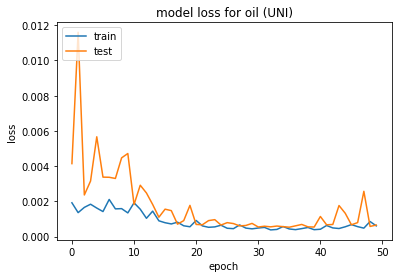

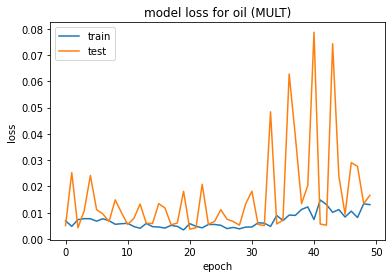

In [51]:
# OIL 
plt.plot(model_trained_oil_uni.history['loss'])
plt.plot(model_trained_oil_uni.history['val_loss'])
plt.title('model loss for oil (UNI)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(model_trained_oil_mult.history['loss'])
plt.plot(model_trained_oil_mult.history['val_loss'])
plt.title('model loss for oil (MULT)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

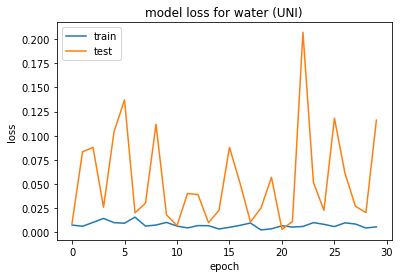

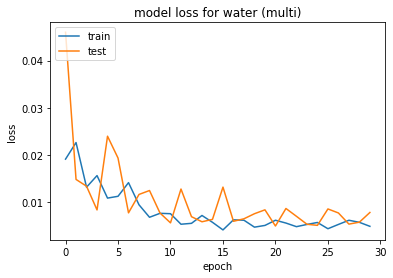

In [52]:
# WATER
plt.plot(model_trained_water_uni.history['loss'])
plt.plot(model_trained_water_uni.history['val_loss'])
plt.title('model loss for water (UNI)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(model_trained_water_mult.history['loss'])
plt.plot(model_trained_water_mult.history['val_loss'])
plt.title('model loss for water (multi)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

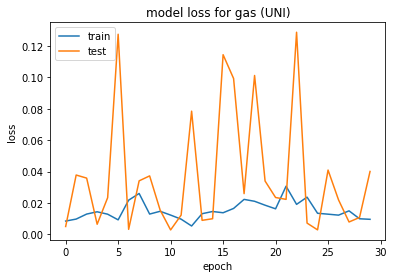

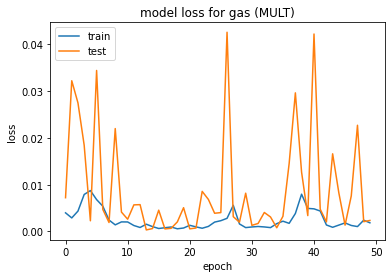

In [53]:
# GAS
plt.plot(model_trained_gas_mult_wll.history['loss'])
plt.plot(model_trained_gas_mult_wll.history['val_loss'])
plt.title('model loss for gas (UNI)')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(model_trained_gas_uni_wll.history['loss'])
plt.plot(model_trained_gas_uni_wll.history['val_loss'])
plt.title('model loss for gas (MULT)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
## gas testing data set visualization
### univariate 
real_gas_uni_well = gas_uni_testY_well.flatten()
pred_gas_uni_well = model_gas_TCN_uni_wll.predict(gas_uni_testX_well).flatten()
df_plot_gas_uni_well=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_gas_uni_well, real_gas_uni_well]))))
df_plot_gas_uni_well['ds']=range(0,len(real_gas_uni_well))
### multivariate 
real_gas_mult_well = gas_mult_testY_well.flatten()
pred_gas_mult_well = model_gas_TCN_mult_wll.predict(gas_mult_testX_well).flatten()
df_plot_gas_mult_well=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_gas_mult_well, real_gas_mult_well]))))
df_plot_gas_mult_well['ds']=range(0,len(real_gas_mult_well))
# water 
# univariate
real_water_uni = water_uni_testY.flatten()
pred_water_uni = model_water_TCN_uni.predict(water_uni_testX).flatten()
df_plot_water_uni=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([ pred_water_uni, real_water_uni]))))
df_plot_water_uni['ds']=range(0,len(real_water_uni))
## multivariate 
real_water_mult = water_mult_testY.flatten()
pred_water_mult = model_water_TCN_mult.predict(water_mult_testX).flatten()
df_plot_water_mult=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([ pred_water_mult, real_water_mult]))))
df_plot_water_mult['ds']=range(0,len(real_water_mult))
## oil
# ## univariate
real_oil_uni = oil_uni_testY.flatten()
pred_oil_uni = model_oil_TCN_uni.predict(oil_uni_testX).flatten()
df_plot_oil_uni=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_oil_uni, real_oil_uni]))))
df_plot_oil_uni['ds']=range(0,len(real_oil_uni))
# ## multivariate 
real_oil_mult = oil_mult_testY.flatten()
pred_oil_mult = model_oil_TCN_mult.predict(oil_mult_testX).flatten()
df_plot_oil_mult=pd.DataFrame.from_dict(dict(zip(['prediction', 'real' ], np.array([pred_oil_mult, real_oil_mult]))))
df_plot_oil_mult['ds']=range(0,len(real_oil_mult))

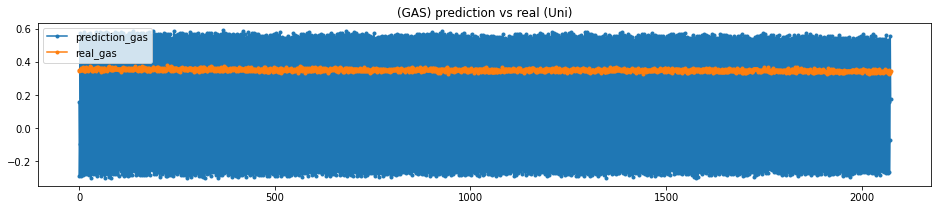

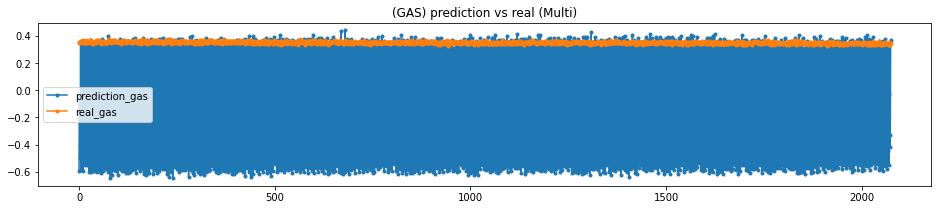

In [19]:
### GAS
start = 0
end = len(df_plot_gas_uni_well)
fig,ax = plt.subplots(figsize=(16,3))
ax.set_title('(GAS) prediction vs real (Uni)')
ax.plot(df_plot_gas_uni_well['ds'].iloc[start:end], df_plot_gas_uni_well['prediction'].iloc[start:end], marker=".", label='prediction_gas')
ax.plot(df_plot_gas_uni_well['ds'].iloc[start:end], df_plot_gas_uni_well['real'].iloc[start:end], marker=".", label='real_gas')
ax.legend()
fig,ax = plt.subplots(figsize=(16,3))
ax.set_title('(GAS) prediction vs real (Multi)')
ax.plot(df_plot_gas_mult_well['ds'].iloc[start:end], df_plot_gas_mult_well['prediction'].iloc[start:end], marker=".", label='prediction_gas')
ax.plot(df_plot_gas_mult_well['ds'].iloc[start:end], df_plot_gas_mult_well['real'].iloc[start:end], marker=".", label='real_gas')
ax.legend()

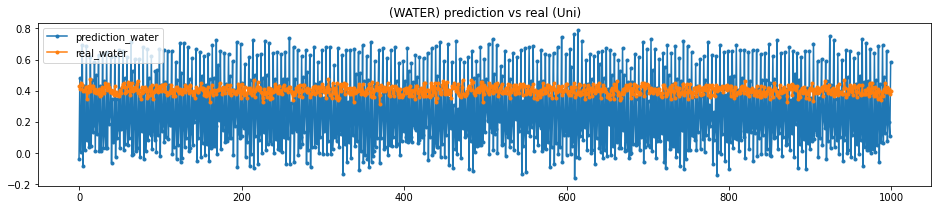

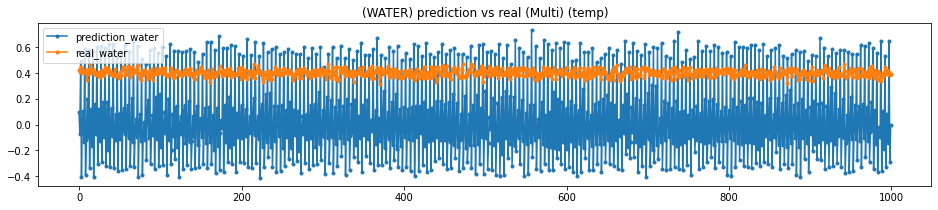

In [20]:
### WATER 
start = 0
end = 1000
fig,ax = plt.subplots(figsize=(16,3))
ax.set_title('(WATER) prediction vs real (Uni)')
ax.plot(df_plot_water_uni['ds'].iloc[start:end], df_plot_water_uni['prediction'].iloc[start:end], marker=".", label='prediction_water')
ax.plot(df_plot_water_uni['ds'].iloc[start:end], df_plot_water_uni['real'].iloc[start:end], marker=".", label='real_water')
ax.legend()
fig,ax = plt.subplots(figsize=(16,3))
ax.set_title('(WATER) prediction vs real (Multi) (temp)')
ax.plot(df_plot_water_mult['ds'].iloc[start:end], df_plot_water_mult['prediction'].iloc[start:end], marker=".", label='prediction_water')
ax.plot(df_plot_water_mult['ds'].iloc[start:end], df_plot_water_mult['real'].iloc[start:end], marker=".", label='real_water')
ax.legend()
# the normalizaation and outliers, normlaize the output

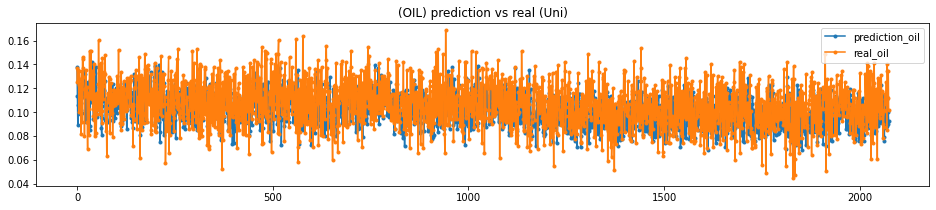

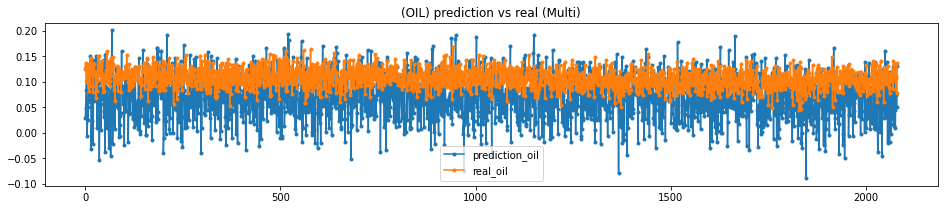

In [57]:
## OIL
start = 0
end = len(df_plot_oil_mult)
fig,ax = plt.subplots(figsize=(16,3))
ax.set_title('(OIL) prediction vs real (Uni)')
ax.plot(df_plot_oil_uni['ds'].iloc[start:end], df_plot_oil_uni['prediction'].iloc[start:end], marker=".", label='prediction_oil')
ax.plot(df_plot_oil_uni['ds'].iloc[start:end], df_plot_oil_uni['real'].iloc[start:end], marker=".", label='real_oil')
ax.legend()
fig,ax = plt.subplots(figsize=(16,3))
ax.set_title('(OIL) prediction vs real (Multi)')
ax.plot(df_plot_oil_mult['ds'].iloc[start:end], df_plot_oil_mult['prediction'].iloc[start:end], marker=".", label='prediction_oil')
ax.plot(df_plot_oil_mult['ds'].iloc[start:end], df_plot_oil_mult['real'].iloc[start:end], marker=".", label='real_oil')
ax.legend()